In [6]:
import pandas as pd
import numpy as np
from sklearn import naive_bayes
import os
import sys
import re
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pickle
import s3fs

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utils import process_tweet

In [4]:
#Reading the training data file
data = pd.read_csv("s3://twitter-sentiment-laks/processed/sentiment_label_data.csv")
data.sample(5)

,Unnamed: 0,sentiment,text
361790,321261,0,GGGRRRR!!! my brO juSt wouLd'nT stuDy! aNd i H...
389479,1432198,1,trying to get a few more things in before i cr...
847464,151471,0,"@schpooner yeah, sorry but my company lost the..."
852321,1146968,1,@jessward123 LOL oh i get it Go to sleep mayb...
919197,1360595,1,packing my lil life away can't wait!!!!!


In [5]:
#cleaning the tweets 
data["tweets"] = data["text"].map(lambda x : process_tweet(x))

In [7]:
#Added column clean_tweet to store te processed tweets 
data["tweets"].sample(10)

42650             swinging at the first stinking pitch  #fb
116644    @denyseduhaime it's nice to see that someone w...
146922                 @bouchrainparis heyy  i'm good! you?
210545    @sarahlowndes fashion conspiracy!!! they're tr...
106756    stookie!!  http://bit.ly/p858a   i never learn...
992368    i looked all entries on the joanna's blog ! wo...
59695     days go by so fast.  it seemed like just 2 bli...
178460    omg, @anneeee is teaching me and sherylp ss!  ...
430631    @backpackingdad   when you get a chance, you r...
449991    @macpowell @marklee3d and eeryone else- i just...
Name: tweets, dtype: object

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['tweets'], data['sentiment'], test_size = 0.333, random_state=0)

In [9]:
X_train[0]

'actually loves her life right now '

In [10]:
y_train[0]

1

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(X_train)


In [12]:
#vect.get_feature_names()[::10]

In [13]:
X_train_vectorized = vect.transform(X_train)

In [14]:
#Training the model
clfrNB = naive_bayes.MultinomialNB()
clfrNB.fit(X_train_vectorized, y_train)

MultinomialNB()

In [15]:
#Vectorizing and predicting the labels 
X_test_vectorized = vect.transform(X_test)
predicted_labels = clfrNB.predict(X_test_vectorized)

In [16]:
# Metrics to evaluate the model
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score (y_test, predicted_labels))

AUC: 0.7784479901947597


In [17]:
# Confusion Matrix to evaluate for binary classification
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predicted_labels,labels=clfrNB.classes_ )
confusion_matrix = confusion_matrix.astype(int)
print(confusion_matrix)
# TODO: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

[[136471  30125]
 [ 43644 122760]]


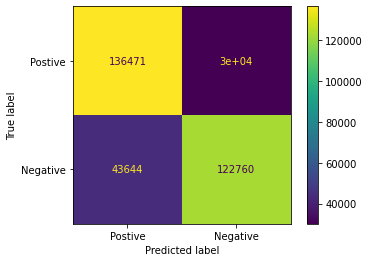

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Postive', 'Negative'])
disp.plot()

In [19]:
#Calculating precision, recall, f1_score 
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
print('Precision    : %.3f'%precision_score(y_test, predicted_labels))
print('Recall       : %.3f'%recall_score(y_test, predicted_labels))
print('F1 Score     : %.3f'%f1_score(y_test, predicted_labels))

Precision    : 0.803
Recall       : 0.738
F1 Score     : 0.769


In [20]:
## Loading the model to S3
model_dir='s3://twitter-sentiment-laks/trained_models/'
file_name=model_dir+'naive_bayes_classification.sav'
print(file_name)
fs = s3fs.S3FileSystem(anon=False)
pickle.dump(clfrNB, fs.open(file_name, 'wb'))

s3://twitter-sentiment-laks/trained_models/naive_bayes_classification.sav


In [98]:
#Predicting the Tweet Sentiment using trained model
data = pd.read_csv("../data/processed/processed_tweets.csv")


In [99]:
tweets = tesla_data["clean_tweet"]
tweets_vectorized = vect.transform(tsla_tweets)

In [100]:
#predicting the sentiment of tweets
data["predictions"] = clfrNB.predict(tweets_vectorized)


In [101]:
#Display postive and negative sentiment count
df = tesla_data["predictions"].value_counts()


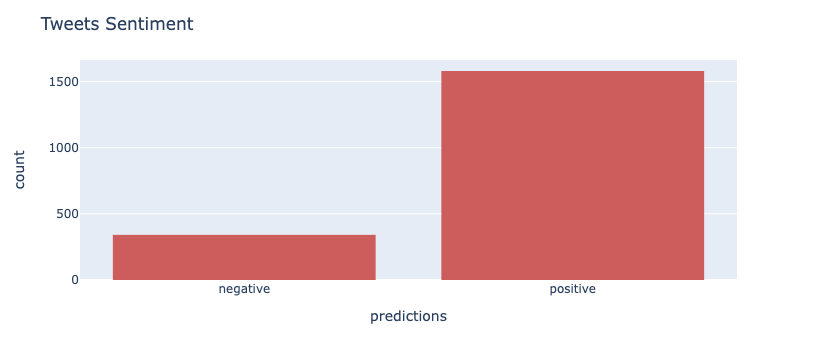

In [106]:
tweet_predictions_senti = tesla_data
tweet_predictions_senti["predictions"] = tweet_predictions_senti["predictions"].replace({1:'Positive'})
tweet_predictions_senti["predictions"] = tweet_predictions_senti["predictions"].replace({0:'Negative'})
fig = px.histogram(tweet_predictions_senti, x="predictions")
fig.update_traces(marker_color="indianred", marker_line_color='black')
fig.update_layout(title_text="Tweets Sentiment")
fig.show()


In [39]:
# Storing the prediction to csv file
tesla_data.to_csv('../data/output/naive_bayes_sentiment_predictions.csv')